<a href="https://colab.research.google.com/github/nicolegherrera/product_embeddings/blob/main/product_embeddings_nicole_herrera.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Finding similarites in items in instacart dataset from Kaggle**

In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from gensim.test.utils import get_tmpfile
from datetime import datetime
%matplotlib inline

In [3]:
# loading datasets from instacart dataset

orders = (pd.read_csv('order_products__train.csv')
          ._append(pd.read_csv('order_products__prior.csv'))
         )
products = pd.read_csv('products.csv')

In [4]:
relevant_cols = ['order_id','product_name']

#downsample while I test the code for faster iteration on syntax. run full dataset before commit.
sample_size = 1

baskets = (orders
           .merge(products,on='product_id',how='left')
           .sample(frac=sample_size)
          )[relevant_cols]

#memory management on my local computer
del([orders,products])

In [5]:
baskets.sort_values(['order_id']).head(20)

,order_id,product_name
1,1,Organic 4% Milk Fat Whole Milk Cottage Cheese
7,1,Organic Whole String Cheese
6,1,Organic Hass Avocado
5,1,Bag of Organic Bananas
4,1,Lightly Smoked Sardines in Olive Oil
2,1,Organic Celery Hearts
3,1,Cucumber Kirby
0,1,Bulgarian Yogurt
1384622,2,Carrots
1384620,2,Coconut Butter


### Embedding Size

This will matter as we use gensim's word2vec implementation for this task. The learning task for word2vec is predicting the a missing word given a window of words around it using a single hidden layer.  Rather than caring about the quality of the prediction, the weights of the hidden layer are what represent the product embedding that we will use. The number of neurons in the hidden layer is a tunable parameter. Unfortunately, there isn't great guidance on select for this, but eyeballing the resulting embeddings can give guidance on quality of fit. Some people recommend using the 4th root of unique tokens in our corpus, which I'll try.

A tunable parameter for the algorithm is the context window, how many words around the target word to use for our prediction task. Given the lack of order, we will want to use the size of the largest basket, 145 for this parameter.

In [6]:
num_items = baskets.product_name.nunique()
embedding_size = np.floor(num_items**0.25).astype('int')
print('''Let's use vectors of length {n} for {tokens} products'''.format(n=embedding_size, tokens = num_items))

biggest_basket = np.max(baskets.groupby('order_id').product_name.nunique())
print('''The biggest basket (window in our algorithm) will be {}'''.format(biggest_basket))

Let's use vectors of length 14 for 49611 products
The biggest basket (window in our algorithm) will be 145


### Shaping our Data
The gensim implementation of word2vec expects each document to be a list. Traditionally, each document is a list of words. In this case, each basket is a list of products. We will use the product name, which will be more expensive in memory but will make interpretation easier.

In [7]:
df_of_basket_lists = (baskets
        .groupby('order_id')
        .apply(lambda baskets :
                baskets.product_name
                .tolist()
               )
       )

#memory management
del(baskets)

<ipython-input-7-2c5650db8566>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda baskets :


### **we have 2,389,653 lists of baskets/orders. Each order ID is a basket.**

In [8]:
df_of_basket_lists.head()
print(len(df_of_basket_lists))

2389653


### **Creating the model**

In [9]:
model = Word2Vec(df_of_basket_lists, vector_size=embedding_size, window=biggest_basket)

In [10]:
def cosine_similarity(word_u,word_v,model):
    """
    Cosine similarity gets the similarity for two products and computes the similarity
    between two embeddings in our word2vec model

    Arguments:
        u - numpy array of shape (n,)
        v - numpy array of shape (n,)

    Returns:
        cosine similarity between words u & v
    """
    #get embeddings from gensim model
    u = model.wv[word_u]
    v = model.wv[word_v]

    #compute similarity
    dot = np.dot(u, v)
    norm_u = np.sqrt(np.sum(u * u))
    norm_v = np.sqrt(np.sum(v * v))
    cosine_similarity = dot / (norm_u * norm_v)

    return cosine_similarity

### **Understanding All products available**

In [16]:
model.wv.key_to_index

{'Banana': 0,
 'Bag of Organic Bananas': 1,
 'Organic Strawberries': 2,
 'Organic Baby Spinach': 3,
 'Organic Hass Avocado': 4,
 'Organic Avocado': 5,
 'Large Lemon': 6,
 'Strawberries': 7,
 'Limes': 8,
 'Organic Whole Milk': 9,
 'Organic Raspberries': 10,
 'Organic Yellow Onion': 11,
 'Organic Garlic': 12,
 'Organic Zucchini': 13,
 'Organic Blueberries': 14,
 'Cucumber Kirby': 15,
 'Organic Fuji Apple': 16,
 'Organic Lemon': 17,
 'Organic Grape Tomatoes': 18,
 'Seedless Red Grapes': 19,
 'Apple Honeycrisp Organic': 20,
 'Organic Cucumber': 21,
 'Honeycrisp Apple': 22,
 'Organic Baby Carrots': 23,
 'Sparkling Water Grapefruit': 24,
 'Organic Half & Half': 25,
 'Organic Large Extra Fancy Fuji Apple': 26,
 'Yellow Onions': 27,
 'Organic Gala Apples': 28,
 'Organic Baby Arugula': 29,
 'Carrots': 30,
 'Fresh Cauliflower': 31,
 'Original Hummus': 32,
 'Organic Cilantro': 33,
 'Half & Half': 34,
 'Asparagus': 35,
 'Organic Red Onion': 36,
 'Organic Small Bunch Celery': 37,
 'Michigan Organic

In [11]:
#a pair of similar identity items
cosine_similarity('Organic Whole Milk','Organic Reduced Fat Milk',model)

0.948819

In [26]:
# a pair of similar items within a department
cosine_similarity('Bag of Organic Bananas','Apple Honeycrisp Organic',model)

0.8461028

In [13]:
# a pair of very different items
cosine_similarity('Bag of Organic Bananas','Party Tumblers',model)

-0.36477548

In [14]:
cosine_similarity('100% Columbian Coffee', 'Coffee Liqueur', model)

0.53050643

In [15]:
cosine_similarity('100% Columbian Coffee', 'Natural Cane Turbinado Sugar', model)

-0.06269854

In [17]:
model.wv.most_similar(positive=["Cauliflower", "Mozzarella Cheese"], negative=["Organic String Cheese"], topn=5)

[('Green Cabbage', 0.944575309753418),
 ('Green Onions', 0.8958992958068848),
 ('Red Potatoes', 0.8871387839317322),
 ('Hoisin Sauce', 0.8705633282661438),
 ('Yellow Straightneck Squash', 0.8684878945350647)]

### **I used the word 2 vec methods instead of cosine similarity, and it works too.**

In [18]:
model.wv.similarity("Fig Newmans Fruit Filled Cookies", "Organic 85% Cacao Dark Chocolate Bar")

0.26235154

In [19]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.index_to_key), sample)
#            words = np.random.choice(list(model.vocab.keys()), sample)

        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]

    plt.figure(figsize=(16,10))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

In [21]:
model.wv.most_similar('Original Popcorn')


[('Salted Caramel Lean Protein & Fiber Bar', 0.8398228287696838),
 ('Brownie Crunch High Protein Bar', 0.8214451670646667),
 ('Cheddar Cheese Nut Thins Cracker Snacks', 0.8214184641838074),
 ('Chunky Peanut Butter High Protein Bar', 0.8209657669067383),
 ('Chocolate Fudge High Protein Bar', 0.8148109316825867),
 ('Lean Protein & Fiber Bar Chocolate Almond Brownie', 0.8127476572990417),
 ('Caramel Fudge High Protein Bar', 0.8080804347991943),
 ('Lean Protein & Fiber Bar Chunky Chocolate Peanut', 0.8038145899772644),
 ('Real Sweet Potato Vegetable Chips', 0.7968589067459106),
 ('Boomchickapop Sea Salt Popcorn', 0.7876365780830383)]

In [22]:
# same aisle same category
products_draw = ['Spicy Chicken Breast Patties', 'Gluten Free Crispy Battered Haddock',
'Key West Pink Shrimp',
'Potato Crunch Fish Fillets',
'Classic Seasoning with Lemon Skillet Crisp Tilapia',
'Mini Crispy Crabless Cakes',
'Whole Grain Breaded Chicken Breast Chunks',
'Chipotle Black Bean Burger',
'Cracked Peppercorn Tilapia',
'Angus Beef Meatballs',
'Crispy Strips',
'Chicken Fingers',
'Patties, Beef, Quarter Pound',
'Original Turkey Burgers Smoke Flavor Added',
'Tortilla Crusted Tilapia',
'Crispy Chicken',
'Breaded Vegan Coconut Shrimp',
'Breaded Chicken Patties',
'Crab Cakes',
'Breaded Nuggets Chicken Breast']

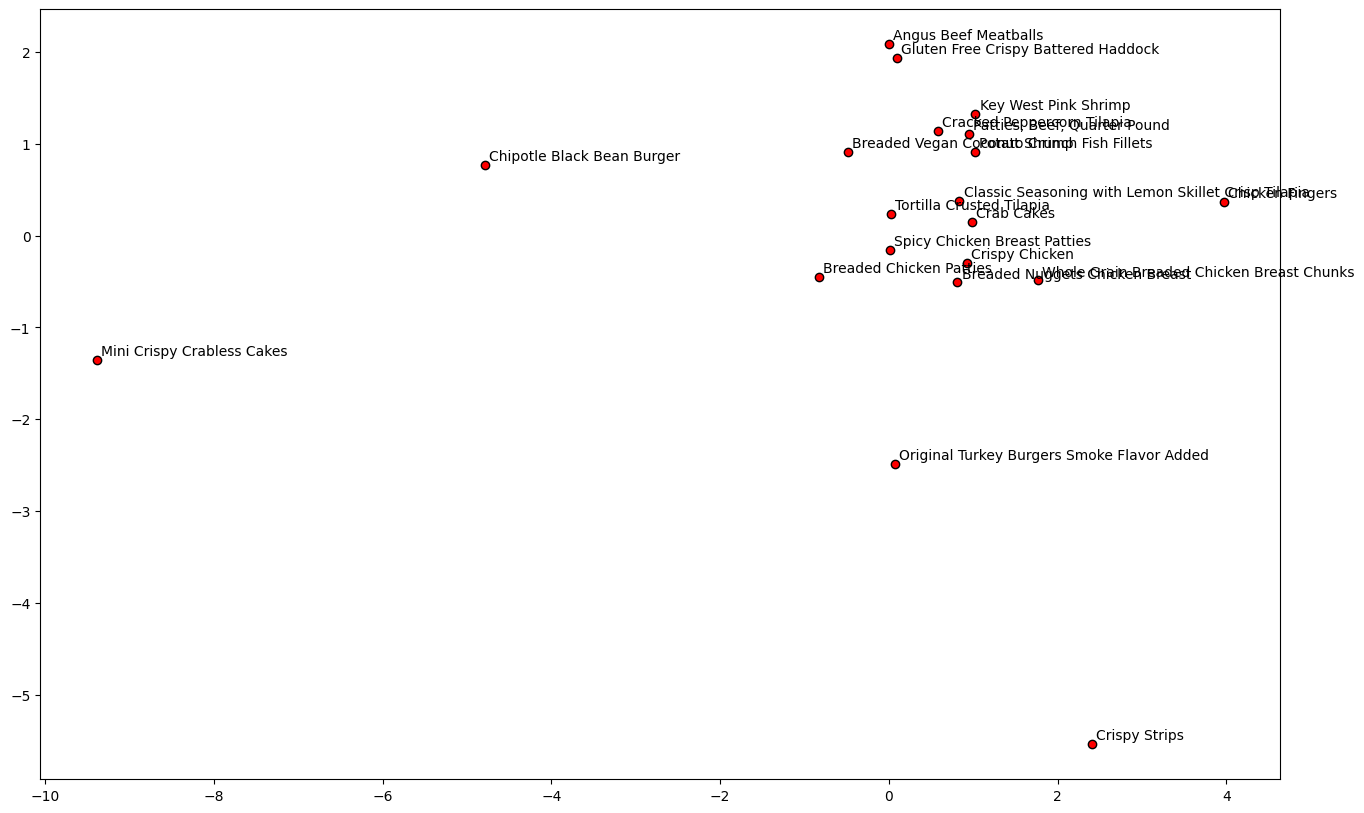

In [23]:
display_pca_scatterplot(model.wv, products_draw)
plt.show()

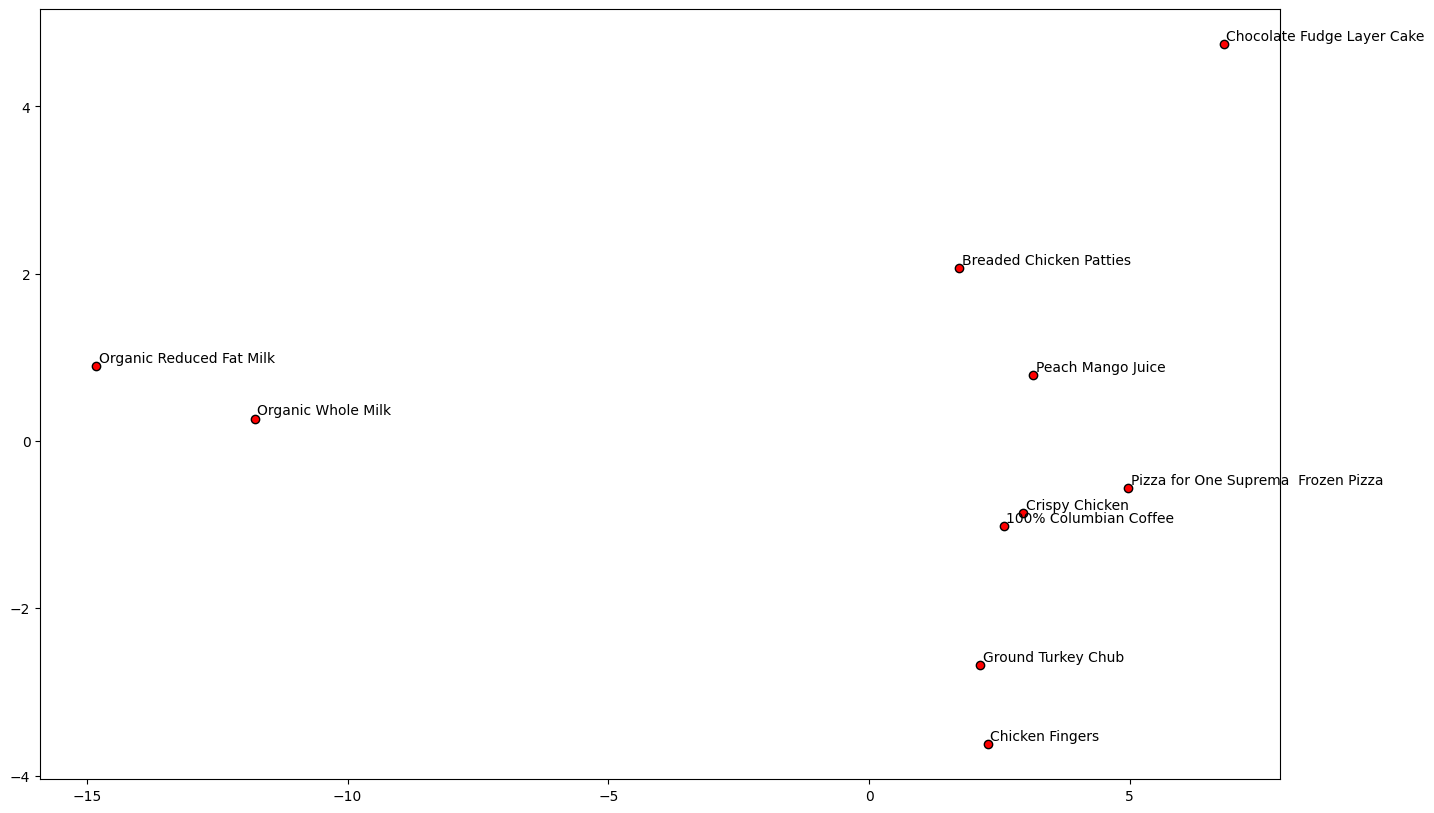

In [24]:
products_raw=['Peach Mango Juice',
'Chocolate Fudge Layer Cake',
'Pizza for One Suprema  Frozen Pizza',
'Chicken Fingers',
              '100% Columbian Coffee',
'Breaded Chicken Patties',
'Organic Whole Milk','Organic Reduced Fat Milk',
'Crispy Chicken',
'Ground Turkey Chub']
display_pca_scatterplot(model.wv, products_raw)
plt.show()